In [70]:
import sys
sys.path.append("../../")

from src.analysis.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [71]:
def load_and_prepare_data(file_path):
    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])

    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]

    price_matrix = df.pivot(index='date', columns='symbol', values='close')

    symbols = price_matrix.columns.tolist()

    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")

    return df, price_matrix, symbols

In [72]:
import toml

with open("../config.toml", "r") as f:
    config = toml.load(f)
    
df, price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'])

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 94
Total trading days: 985


In [73]:
returns_matrix = price_matrix.pct_change()
returns_matrix = returns_matrix.dropna() 

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_returns = pd.DataFrame(
    scaler.fit_transform(returns_matrix),
    index=returns_matrix.index,
    columns=returns_matrix.columns
)

In [75]:
def calculate_rolling_correlation(returns_df, window=250):
    pairs_corr = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            rolling_corr = returns_df[[sym1, sym2]].rolling(window=window)\
                          .corr()\
                          .unstack()[sym2][sym1]
                          
            pairs_corr[pair_key] = rolling_corr
            
    return pd.DataFrame(pairs_corr)

rolling_correlations = calculate_rolling_correlation(standardized_returns)
rolling_correlations = rolling_correlations.dropna()

In [76]:
def calculate_rolling_betas(returns_df, window=250):
    pairs_beta = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            x = returns_df[sym2]
            y = returns_df[sym1]
            
            rolling_cov = y.rolling(window=window).cov(x)
            rolling_var = x.rolling(window=window).var()
            rolling_beta = rolling_cov / rolling_var
            
            pairs_beta[pair_key] = rolling_beta
            
    return pd.DataFrame(pairs_beta)

rolling_betas = calculate_rolling_betas(standardized_returns)
rolling_betas = rolling_betas.dropna()

In [77]:
def calculate_residuals_std(returns_df, window=250):
    pairs_residuals = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            x = returns_df[sym2].values
            y = returns_df[sym1].values
            
            residuals = [np.nan] * len(returns_df)
            for k in range(window, len(returns_df) + 1):
                window_x = x[k-window:k]
                window_y = y[k-window:k]
                coeffs = np.polyfit(window_x, window_y, 1)
                pred = np.polyval(coeffs, window_x)
                window_residuals = window_y - pred
                residuals[k-1] = np.std(window_residuals)
                
            pairs_residuals[pair_key] = residuals
            
    return pd.DataFrame(pairs_residuals, index=returns_df.index)

rolling_residuals_std = calculate_residuals_std(standardized_returns)
rolling_residuals_std = rolling_residuals_std.dropna()

In [78]:
def calculate_spread_deviation(returns_df, window=250, holding_period=5, zscore_threshold=2):
    pairs_spread_dev = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            spread = returns_df[sym1] - returns_df[sym2]
            rolling_mean = spread.rolling(window=window).mean()
            rolling_std = spread.rolling(window=window).std()
            zscore = (spread - rolling_mean) / rolling_std
            
            entry_signals = abs(zscore) > zscore_threshold
            spread_changes = []
            
            for k in range(window, len(returns_df) - holding_period):
                if entry_signals.iloc[k]:
                    spread_t0 = spread.iloc[k]
                    spread_t1 = spread.iloc[k + holding_period]
                    spread_change = abs(spread_t1 - spread_t0)
                    spread_changes.append(spread_change)
            
            if spread_changes:
                pairs_spread_dev[pair_key] = np.mean(spread_changes)
            else:
                pairs_spread_dev[pair_key] = np.nan
                
    return pd.Series(pairs_spread_dev)

average_spread_deviation = calculate_spread_deviation(standardized_returns)
average_spread_deviation = average_spread_deviation.dropna()

print(f"Anzahl der berechneten Paare: {len(average_spread_deviation)}")
print("\nTop 5 Paare mit niedrigster Spread-Abweichung:")
print(average_spread_deviation.nsmallest(5))

Anzahl der berechneten Paare: 4371

Top 5 Paare mit niedrigster Spread-Abweichung:
GOOG_GOOGL    0.189896
AMAT_LRCX     0.953922
KLAC_LRCX     1.136990
AMAT_KLAC     1.218381
MCHP_NXPI     1.360034
dtype: float64


In [79]:
feature_df = pd.DataFrame({
   'correlation': rolling_correlations.iloc[-1],
   'beta': rolling_betas.iloc[-1],
   'residuals_std': rolling_residuals_std.iloc[-1]
})

feature_df['target'] = average_spread_deviation
feature_df = feature_df.dropna()

volume_matrix = df.pivot(index='date', columns='symbol', values='volume')

In [80]:
def calculate_volume_features(volume_df, pairs, windows=[50, 100]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for window in windows:
            vol1 = volume_df[sym1].rolling(window=window)
            vol2 = volume_df[sym2].rolling(window=window)
            
            pair_features[f'vol_avg_{window}'] = ((vol1.mean() + vol2.mean()) / 2).iloc[-1]
            pair_features[f'vol_std_{window}'] = ((vol1.std() + vol2.std()) / 2).iloc[-1]
            pair_features[f'vol_change_{window}'] = ((volume_df[sym1].pct_change() + volume_df[sym2].pct_change()) / 2).rolling(window=window).mean().iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [81]:
volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df[['correlation', 'beta', 'residuals_std', 'target']],
    volume_features,
], axis=1)

In [82]:
def calculate_roc_features(price_df, volume_df, pairs, windows=[5, 20, 50]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for window in windows:
            # Price ROC
            price_roc_1 = price_df[sym1].pct_change(window)
            price_roc_2 = price_df[sym2].pct_change(window)
            
            pair_features[f'ROC_SYM1_{window}d'] = price_roc_1.iloc[-1]
            pair_features[f'ROC_SYM2_{window}d'] = price_roc_2.iloc[-1]
            pair_features[f'ROC_diff_{window}d'] = price_roc_1.iloc[-1] - price_roc_2.iloc[-1]
            
            # Volume ROC
            vol_roc_1 = volume_df[sym1].pct_change(window)
            vol_roc_2 = volume_df[sym2].pct_change(window)
            
            pair_features[f'vol_ROC_SYM1_{window}d'] = vol_roc_1.iloc[-1]
            pair_features[f'vol_ROC_SYM2_{window}d'] = vol_roc_2.iloc[-1]
            pair_features[f'vol_ROC_diff_{window}d'] = vol_roc_1.iloc[-1] - vol_roc_2.iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [83]:
roc_features = calculate_roc_features(price_matrix, volume_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    roc_features
], axis=1)

In [84]:
def calculate_williams_r_features(price_df, pairs, windows=[10, 14, 28, 40]):
   features = {}
   
   for pair in pairs:
       sym1, sym2 = pair.split('_')
       pair_features = {}
       
       for window in windows:
           # Williams %R für Symbol 1
           high1 = price_df[sym1].rolling(window=window).max()
           low1 = price_df[sym1].rolling(window=window).min()
           williams_r1 = ((high1 - price_df[sym1]) / (high1 - low1) * -100)
           
           # Williams %R für Symbol 2
           high2 = price_df[sym2].rolling(window=window).max()
           low2 = price_df[sym2].rolling(window=window).min()
           williams_r2 = ((high2 - price_df[sym2]) / (high2 - low2) * -100)
           
           pair_features[f'WilliamsR_SYM1_{window}d'] = williams_r1.iloc[-1]
           pair_features[f'WilliamsR_SYM2_{window}d'] = williams_r2.iloc[-1]
           pair_features[f'WilliamsR_diff_{window}d'] = williams_r1.iloc[-1] - williams_r2.iloc[-1]
       
       features[pair] = pair_features
   
   return pd.DataFrame.from_dict(features, orient='index')

In [85]:
williams_r_features = calculate_williams_r_features(price_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    williams_r_features
], axis=1)

In [86]:
def calculate_bollinger_bands_width(returns_df, pairs, windows=[5, 10, 20, 25, 50]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        spread = returns_df[sym1] - returns_df[sym2]
        
        for window in windows:
            sma = spread.rolling(window=window).mean()
            std = spread.rolling(window=window).std()
            
            bb_width = (2 * std) / sma * 100
            pair_features[f'BB_width_{window}d'] = bb_width.iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [87]:
bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    bollinger_bands_features
], axis=1)

In [88]:
def calculate_macd_features(price_df, pairs, params=[
    {'fast': 12, 'slow': 26, 'signal': 9},
    {'fast': 5, 'slow': 13, 'signal': 5}
]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for p in params:
            period = f"{p['fast']}_{p['slow']}_{p['signal']}"
            
            for sym in [sym1, sym2]:
                fast_ema = price_df[sym].ewm(span=p['fast']).mean()
                slow_ema = price_df[sym].ewm(span=p['slow']).mean()
                macd_line = fast_ema - slow_ema
                signal_line = macd_line.ewm(span=p['signal']).mean()
                histogram = macd_line - signal_line
                
                if sym == sym1:
                    macd_line_1 = macd_line
                    signal_line_1 = signal_line
                    histogram_1 = histogram
                else:
                    macd_line_2 = macd_line
                    signal_line_2 = signal_line
                    histogram_2 = histogram
            
            pair_features[f'MACD_line_diff_{period}'] = (macd_line_1 - macd_line_2).iloc[-1]
            pair_features[f'Signal_line_diff_{period}'] = (signal_line_1 - signal_line_2).iloc[-1]
            pair_features[f'MACD_hist_diff_{period}'] = (histogram_1 - histogram_2).iloc[-1]
            pair_features[f'MACD_cross_{period}_SYM1'] = 1 if macd_line_1.iloc[-1] > signal_line_1.iloc[-1] else 0
            pair_features[f'MACD_cross_{period}_SYM2'] = 1 if macd_line_2.iloc[-1] > signal_line_2.iloc[-1] else 0
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [89]:
macd_features = calculate_macd_features(price_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    macd_features
], axis=1)

##### Grid Search 
```Python
param_grid = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [2, 3, 4], 
    'min_samples_split': [2, 4], 
    'min_samples_leaf': [1, 2] 
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42), 
    param_grid=param_grid, 
    scoring='r2', 
    cv=5, # Important !
    n_jobs=-1, 
    verbose=2 
)
```

In [90]:
feature_columns = [
    'correlation', 'beta', 'residuals_std',
    'vol_change_50',
    'ROC_SYM2_20d',
    'vol_ROC_SYM1_50d',
    'vol_ROC_SYM2_5d',
    'ROC_SYM1_50d',
    'vol_ROC_SYM2_20d',
    'vol_ROC_SYM1_20d',
    'WilliamsR_SYM1_40d',
    'vol_ROC_SYM1_5d',
    'ROC_SYM1_5d',
    'vol_ROC_SYM2_50d',
    'ROC_SYM2_50d',
    'residuals_std',
    'ROC_SYM1_20d',
    'WilliamsR_SYM2_28d',
    'ROC_SYM2_5d', 
    'WilliamsR_SYM1_28d',
    'WilliamsR_SYM2_14d',
    'beta', 
    'WilliamsR_SYM1_14d',
    'vol_avg_100',
    'MACD_line_diff_12_26_9',
    'vol_avg_50',
    'vol_ROC_diff_50d',
    'WilliamsR_SYM2_40d',
    'MACD_cross_12_26_9_SYM2',
    'vol_change_100',
    'MACD_hist_diff_12_26_9',
    'vol_std_50'
]

In [91]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd 
from sklearn.model_selection import train_test_split 

X = feature_df[feature_columns]
y = feature_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_params_grid_search = {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

final_model_retrained = GradientBoostingRegressor(**best_params_grid_search, random_state=42) 
final_model_retrained.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=2, min_samples_leaf=2,
                          n_estimators=300, random_state=42)

### Evaluation

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = final_model_retrained.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.3f}')
print(f'MSE: {mean_squared_error(y_test, y_pred):.3f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')

R2: 0.707
MSE: 0.068
MAE: 0.201


In [93]:
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model_retrained.feature_importances_
}).sort_values('importance', ascending=False)

# Einfache Listenausgabe der Top 30 Features
for idx, row in importance.head(30).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

correlation: 0.5185
vol_change_50: 0.0539
ROC_SYM1_20d: 0.0420
ROC_SYM2_20d: 0.0382
WilliamsR_SYM2_28d: 0.0296
vol_ROC_SYM1_5d: 0.0242
vol_ROC_SYM2_50d: 0.0242
vol_ROC_SYM1_20d: 0.0237
vol_ROC_SYM2_5d: 0.0189
ROC_SYM2_50d: 0.0178
vol_ROC_SYM1_50d: 0.0176
WilliamsR_SYM1_40d: 0.0170
vol_ROC_SYM2_20d: 0.0165
ROC_SYM1_50d: 0.0138
WilliamsR_SYM1_28d: 0.0127
WilliamsR_SYM1_14d: 0.0122
vol_avg_50: 0.0120
WilliamsR_SYM2_14d: 0.0117
ROC_SYM2_5d: 0.0114
ROC_SYM1_5d: 0.0100
residuals_std: 0.0099
vol_change_100: 0.0080
MACD_hist_diff_12_26_9: 0.0079
residuals_std: 0.0071
MACD_line_diff_12_26_9: 0.0065
WilliamsR_SYM2_40d: 0.0064
vol_avg_100: 0.0063
beta: 0.0059
beta: 0.0055
vol_std_50: 0.0055


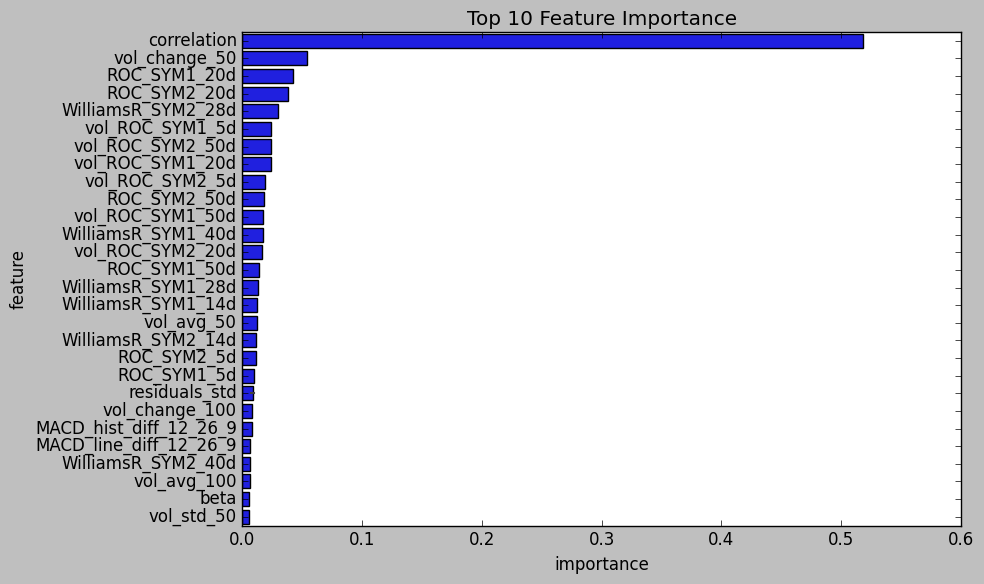

In [94]:
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model_retrained.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(30), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

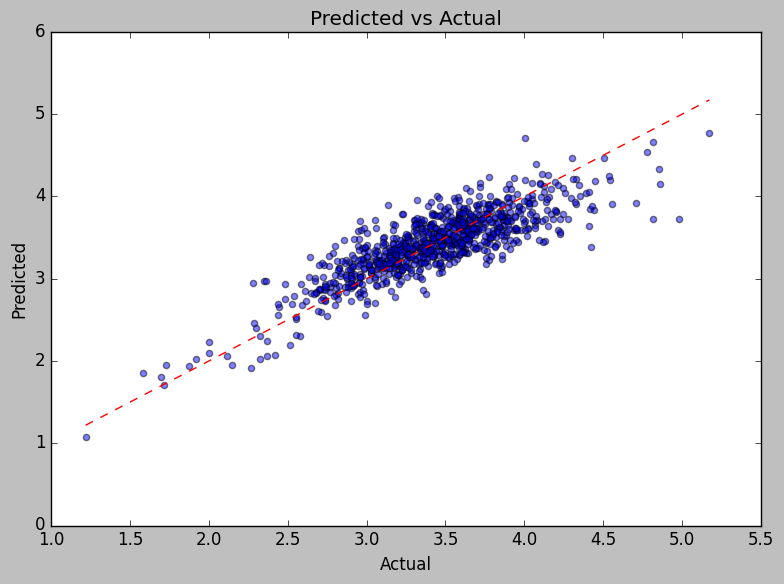

In [95]:
# Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()

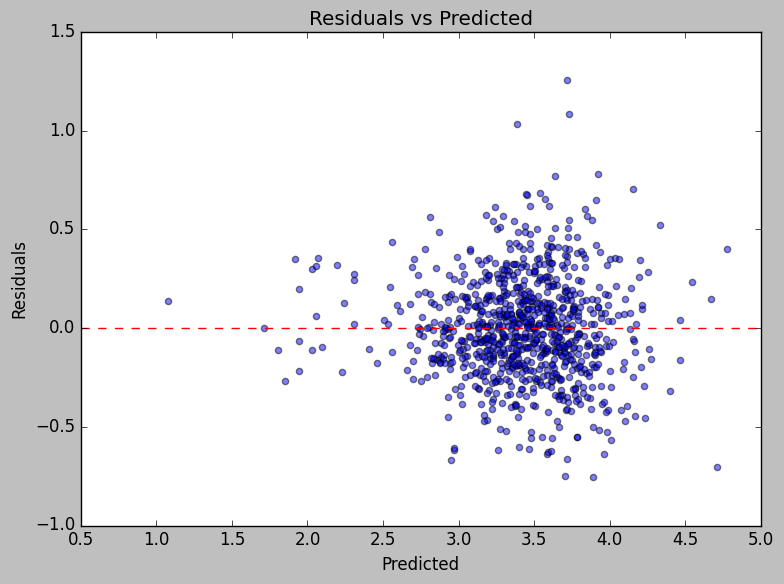

In [96]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

### Walk-Forward Evaluation

In [97]:
walk_forward_dates = []
current_train_start = DATE_CONFIG['TRAIN_START']
current_train_end = DATE_CONFIG['TRAIN_END']
step_size = timedelta(days=90)  
while current_train_end <= DATE_CONFIG['TEST_END']:
    walk_forward_dates.append({
        'TRAIN_START': current_train_start,
        'TRAIN_END': current_train_end
    })
    current_train_start += step_size
    current_train_end += step_size

walk_forward_results = []

for wf_config in tqdm(walk_forward_dates, desc="Walk-Forward Iteration"):
    DATE_CONFIG['TRAIN_START'] = wf_config['TRAIN_START']
    DATE_CONFIG['TRAIN_END'] = wf_config['TRAIN_END']

    df, price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'])
    returns_matrix = price_matrix.pct_change().dropna()

    scaler = StandardScaler()
    standardized_returns = pd.DataFrame(
        scaler.fit_transform(returns_matrix),
        index=returns_matrix.index,
        columns=returns_matrix.columns
    )

    rolling_correlations = calculate_rolling_correlation(standardized_returns)
    rolling_correlations = rolling_correlations.dropna()
    rolling_betas = calculate_rolling_betas(standardized_returns)
    rolling_betas = rolling_betas.dropna()
    rolling_residuals_std = calculate_residuals_std(standardized_returns)
    rolling_residuals_std = rolling_residuals_std.dropna()
    average_spread_deviation = calculate_spread_deviation(standardized_returns)
    average_spread_deviation = average_spread_deviation.dropna()

    feature_df = pd.DataFrame({
        'correlation': rolling_correlations.iloc[-1],
        'beta': rolling_betas.iloc[-1],
        'residuals_std': rolling_residuals_std.iloc[-1]
    })
    feature_df['target'] = average_spread_deviation
    feature_df = feature_df.dropna()

    volume_matrix = df.pivot(index='date', columns='symbol', values='volume')
    volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df[['correlation', 'beta', 'residuals_std', 'target']], volume_features], axis=1)
    roc_features = calculate_roc_features(price_matrix, volume_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, roc_features], axis=1)
    williams_r_features = calculate_williams_r_features(price_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, williams_r_features], axis=1)
    bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, bollinger_bands_features], axis=1)
    macd_features = calculate_macd_features(price_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, macd_features], axis=1)

    X = feature_df[feature_columns]
    y = feature_df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)  # Beachte: Test hier ist Validierung im Walk-Forward

    best_params_grid_search = {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2,
                               'n_estimators': 300}
    final_model_retrained = GradientBoostingRegressor(**best_params_grid_search, random_state=42)
    final_model_retrained.fit(X_train, y_train)
    y_pred = final_model_retrained.predict(X_test)

    results = {
        'TRAIN_START': str(DATE_CONFIG['TRAIN_START']),
        'TRAIN_END': str(DATE_CONFIG['TRAIN_END']),
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    walk_forward_results.append(results)

walk_forward_df = pd.DataFrame(walk_forward_results)

print("\nWalk-Forward Validierungsergebnisse:")
print(walk_forward_df)


average_metrics = walk_forward_df[['R2', 'MSE', 'MAE']].mean()
print("\nDurchschnittliche Metriken über alle Walk-Forward-Schritte:")
print(average_metrics)

plt.figure(figsize=(12, 6))
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['R2'], label='R2')
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['MSE'], label='MSE')
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['MAE'], label='MAE')
plt.xlabel('Train End Date')
plt.ylabel('Metrics')
plt.title('Walk-Forward Validierung Metriken')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Walk-Forward Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 94
Total trading days: 985


Walk-Forward Iteration:   0%|          | 0/5 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [98]:
def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, cluster_timestamp, window1=5, window2=60):
    trades = []
    trade_id = 0
    active_trades = []
    
    S1_full = pd.concat([S1_train, S1_test])
    S2_full = pd.concat([S2_train, S2_test])
    
    ratios_full = S1_full / S2_full
    test_start = S1_test.index[0]
    
    for i in range(len(S1_test)):
        current_idx = S1_train.shape[0] + i
        ratio_history = ratios_full.iloc[:current_idx+1]
        
        if len(ratio_history) < window2:
            continue
            
        ma2 = ratio_history.rolling(window=window2, center=False).mean().iloc[-1]
        std = ratio_history.rolling(window=window2, center=False).std().iloc[-1]
        
        if std == 0:
            continue
            
        current_ratio = ratios_full.iloc[current_idx]
        current_date = S1_test.index[i]
        zscore = (current_ratio - ma2) / std
        
        if zscore > 1.0:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,
                'symbol2': symbol2,
                'entry_date': current_date,
                'entry_zscore': zscore,
                'cluster_timestamp': cluster_timestamp,
                'status': 'active',
                'type': 'short',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'short'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'long'}
                }
            }
            active_trades.append(trade_entry)
            trade_id += 1
            
        elif zscore < -1.0:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,
                'symbol2': symbol2,
                'entry_date': current_date,
                'entry_zscore': zscore,
                'cluster_timestamp': cluster_timestamp,
                'status': 'active',
                'type': 'long',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'long'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'short'}
                }
            }
            active_trades.append(trade_entry)
            trade_id += 1
        
        for trade in active_trades:
            if trade['status'] == 'active':
                if (trade['type'] == 'short' and zscore < 0.5) or \
                   (trade['type'] == 'long' and zscore > -0.5):
                    
                    trade['status'] = 'closed'
                    trade['exit_date'] = current_date
                    trade['exit_zscore'] = zscore
                    
                    for symbol in [symbol1, symbol2]:
                        trades.append({
                            'trade_id': trade['trade_id'],
                            'symbol': symbol,
                            'entry_date': trade['entry_date'],
                            'entry_price': trade['entry_prices'][symbol]['price'],
                            'exit_date': current_date,
                            'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                            'position_type': trade['entry_prices'][symbol]['type'],
                            'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                            'exit_type': 'target',
                            'cluster_timestamp': trade['cluster_timestamp']
                        })
    
    return trades, active_trades

In [99]:
def backtest_pairs_sliding(price_matrix, initial_start_date, initial_end_date, window_shifts=10, p_threshold=0.05):
    all_trades = []
    shift_size = 1
    
    print(f"Price Matrix Zeitraum: {price_matrix.index.min()} bis {price_matrix.index.max()}")
    
    # Get symbols from price matrix columns
    symbols = price_matrix.columns.tolist()
    
    for shift in range(window_shifts):
        if shift == 0:
            current_start = initial_start_date
            current_end = initial_end_date
        else:
            current_start = initial_start_date + pd.DateOffset(months=shift)
            current_end = initial_end_date + pd.DateOffset(months=shift)
        
        print(f"\nAnalyse {shift+1}/{window_shifts}")
        print(f"Cluster-Fenster: {current_start} bis {current_end}")
        
        # Load and prepare data for current window
        cluster_data = price_matrix[(price_matrix.index >= current_start) & 
                                  (price_matrix.index <= current_end)].copy()
        
        if len(cluster_data) == 0:
            print(f"Keine Daten für Fenster {shift+1}")
            continue
            
        print(f"Cluster Daten: {len(cluster_data)} Tage")
        
        # Calculate returns and standardize
        returns_matrix = cluster_data.pct_change()
        returns_matrix = returns_matrix.dropna()
        
        scaler = StandardScaler()
        standardized_returns = pd.DataFrame(
            scaler.fit_transform(returns_matrix),
            index=returns_matrix.index,
            columns=returns_matrix.columns
        )
        
        # Calculate all required features
        rolling_correlations = calculate_rolling_correlation(standardized_returns)
        rolling_correlations = rolling_correlations.dropna()
        rolling_betas = calculate_rolling_betas(standardized_returns)
        rolling_betas = rolling_betas.dropna()
        rolling_residuals_std = calculate_residuals_std(standardized_returns)
        rolling_residuals_std = rolling_residuals_std.dropna()
        average_spread_deviation = calculate_spread_deviation(standardized_returns)
        average_spread_deviation = average_spread_deviation.dropna()

        # Base features
        feature_df = pd.DataFrame({
            'correlation': rolling_correlations.iloc[-1],
            'beta': rolling_betas.iloc[-1],
            'residuals_std': rolling_residuals_std.iloc[-1]
        })
        feature_df['target'] = average_spread_deviation
        feature_df = feature_df.dropna()

        # Create volume matrix from price matrix structure
        volume_matrix = price_matrix.copy()  # Using same structure as price matrix
        
        # Additional features
        volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)
        roc_features = calculate_roc_features(cluster_data, volume_matrix, rolling_correlations.columns)
        williams_r_features = calculate_williams_r_features(cluster_data, rolling_correlations.columns)
        bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)
        macd_features = calculate_macd_features(cluster_data, rolling_correlations.columns)

        # Combine all features
        feature_df = pd.concat([
            feature_df[['correlation', 'beta', 'residuals_std', 'target']],
            volume_features,
            roc_features,
            williams_r_features,
            bollinger_bands_features,
            macd_features
        ], axis=1)

        # Prepare features and target for training
        X = feature_df[feature_columns]
        y = feature_df['target']
        
        # Train gradient boost model for this window
        best_params_grid_search = {
            'learning_rate': 0.2, 
            'max_depth': 2, 
            'min_samples_leaf': 2, 
            'min_samples_split': 2,
            'n_estimators': 300
        }
        model = GradientBoostingRegressor(**best_params_grid_search, random_state=42)
        model.fit(X, y)
        
        # Find cointegrated pairs
        potential_pairs = []
        for i in range(len(symbols)):
            for j in range(i+1, len(symbols)):
                symbol1, symbol2 = symbols[i], symbols[j]
                series1 = cluster_data[symbol1].dropna()
                series2 = cluster_data[symbol2].dropna()
                
                if len(series1) > 0 and len(series2) > 0:
                    score, pvalue, _ = coint(series1, series2)
                    
                    if pvalue < p_threshold:
                        pair_key = f"{symbol1}_{symbol2}"
                        if pair_key in feature_df.index:
                            potential_pairs.append({
                                'pair': (symbol1, symbol2),
                                'pvalue': pvalue,
                                'predicted_spread': model.predict([X.loc[pair_key]])[0]
                            })
        
        if not potential_pairs:
            print(f"Keine kointegrierten Paare gefunden für Fenster {shift+1}")
            continue
            
        # Sort pairs by predicted spread and get top 20
        pairs_df = pd.DataFrame(potential_pairs)
        pairs_df = pairs_df.sort_values('predicted_spread')
        top_pairs = pairs_df['pair'].tolist()[:20]
        
        print(f"Gefundene handelbare Paare für Fenster {shift+1}: {len(top_pairs)}")
        
        trade_start = current_end
        trade_end = min(trade_start + pd.DateOffset(months=1), price_matrix.index.max())
        
        print(f"Trading-Zeitraum: {trade_start} bis {trade_end}")
        
        trading_data = price_matrix[(price_matrix.index > trade_start) & 
                                  (price_matrix.index <= trade_end)].copy()
        
        print(f"Trading Daten: {len(trading_data)} Tage")
        
        if len(trading_data) == 0:
            print(f"Warnung: Kein Trading-Zeitraum verfügbar nach {trade_start}")
            continue
            
        # Execute trades
        trade_count = 0
        for pair in top_pairs:
            symbol1, symbol2 = pair
            
            trades, active_trades = trade(
                cluster_data[symbol1], 
                cluster_data[symbol2],
                trading_data[symbol1], 
                trading_data[symbol2],
                symbol1, symbol2,
                cluster_timestamp=current_end
            )
            
            if trades:
                trade_count += len(trades)
            all_trades.extend(trades)
            
        print(f"Trades in diesem Fenster: {trade_count}")
    
    trades_df = pd.DataFrame(all_trades)
    
    if len(trades_df) > 0:
        trades_df.to_parquet('../../data/results/GradientBoost_Z-Score_Sliding.parquet')
        
        print("\nTrading Zusammenfassung:")
        print(f"Gesamtanzahl Trades: {len(trades_df)}")
        print(f"Unique Paare gehandelt: {len(trades_df[['symbol', 'paired_symbol']].drop_duplicates())}")
        print(f"Zeitraum: {trades_df['entry_date'].min()} bis {trades_df['exit_date'].max()}")
        
        unique_timestamps = trades_df['cluster_timestamp'].unique()
        timestamp_to_window = {ts: idx for idx, ts in enumerate(sorted(unique_timestamps))}
        trades_df['window'] = trades_df['cluster_timestamp'].map(timestamp_to_window)
        
        print("\nTrades pro Fenster:")
        print(trades_df['window'].value_counts().sort_index())
    else:
        print("Keine Trades generiert!")
        
    return trades_df

In [100]:
trades_df = backtest_pairs_sliding(
    price_matrix=price_matrix,
    initial_start_date=DATE_CONFIG['TRAIN_START'],
    initial_end_date=DATE_CONFIG['TRAIN_END'], 
    window_shifts=12
)

Price Matrix Zeitraum: 2021-02-02 00:00:00 bis 2024-12-31 00:00:00

Analyse 1/12
Cluster-Fenster: 2021-02-02 00:00:00 bis 2024-01-01 00:00:00
Cluster Daten: 733 Tage
Gefundene handelbare Paare für Fenster 1: 20
Trading-Zeitraum: 2024-01-01 00:00:00 bis 2024-02-01 00:00:00
Trading Daten: 22 Tage
Trades in diesem Fenster: 220

Analyse 2/12
Cluster-Fenster: 2021-03-02 00:00:00 bis 2024-02-01 00:00:00
Cluster Daten: 736 Tage
Gefundene handelbare Paare für Fenster 2: 20
Trading-Zeitraum: 2024-02-01 00:00:00 bis 2024-03-01 00:00:00
Trading Daten: 20 Tage
Trades in diesem Fenster: 88

Analyse 3/12
Cluster-Fenster: 2021-04-02 00:00:00 bis 2024-03-01 00:00:00
Cluster Daten: 733 Tage
Gefundene handelbare Paare für Fenster 3: 20
Trading-Zeitraum: 2024-03-01 00:00:00 bis 2024-04-01 00:00:00
Trading Daten: 20 Tage
Trades in diesem Fenster: 194

Analyse 4/12
Cluster-Fenster: 2021-05-02 00:00:00 bis 2024-04-01 00:00:00
Cluster Daten: 733 Tage
Gefundene handelbare Paare für Fenster 4: 20
Trading-Zeitr